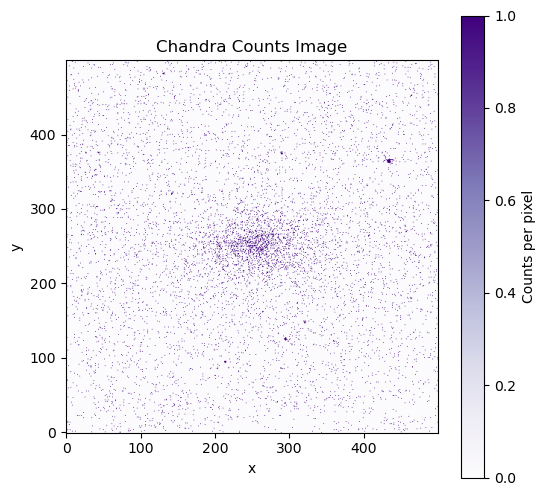

In [64]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

# Load event file
filename = "/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/13468/primary/acisf13468N003_evt2.fits.gz"
with fits.open(filename) as hdul:
    events = hdul["EVENTS"].data

x = events["x"]
y = events["y"]

# Histogram events to make image
nbins = 2048  # 4096 pixels ~ full field; 8192 gives finer sampling
xrange = [x.min(), x.max()]
yrange = [y.min(), y.max()]
img, xedges, yedges = np.histogram2d(x, y, bins=nbins, range=[xrange, yrange])

plt.figure(figsize=(6,6))
cutout = img.T[700:1200,1150:1650]
plt.imshow(cutout, origin="lower", cmap="Purples", vmax=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Chandra Counts Image")
plt.colorbar(label="Counts per pixel")
plt.show()
